# Confounding Factors
---

In [12]:
import pandas as pd
from tqdm.notebook import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from radon.raw import analyze
from radon.metrics import h_visit, mi_visit
from radon.complexity import cc_visit
import radon.visitors
import PIL
import numpy as np
import modules.GenSnippetsLib as snippets
from pygments.lexers import PythonLexer

plt.rcParams['savefig.facecolor'] = 'white'

In [13]:
if not os.path.exists('./results/ConfoundingFactors'):
    os.makedirs('./results/ConfoundingFactors/data')
    os.makedirs('./results/ConfoundingFactors/figures')

# Calculate confounding factors - Complexity Metrics

In [14]:
df = pd.read_csv('./data/preprocessed_experiment_data.csv')
algorithms = df['Algorithm'].unique()
programming_styles = df['ProgrammingStyle'].unique()

In [15]:
df_confounding = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "LinesOfCode", "LogicalLinesOfCode", "SourceLinesOfCode", "MaintainabilityIndex", "CyclomaticComplexity", "HalsteadDifficulty"])

for programming_style in tqdm(programming_styles):
    programming_style = programming_style.replace('-', '_')
    for algorithm in algorithms:
        snippet_path = f"./data/CodeSnippets/Source/{algorithm}_{programming_style}.py"
        # Load code snippet
        with open(snippet_path, 'r') as f:
            code = f.read()
            # Calculate confounding factors
            loc = analyze(code).loc
            lloc = analyze(code).lloc
            sloc = analyze(code).sloc
            mi = mi_visit(code, False)
            data = cc_visit(code)
            cc = 0
            for c in data:
                if isinstance(c, radon.visitors.Class):
                    continue
                cc += c.complexity
            hi = h_visit(code)[0].difficulty
            # Append to dataframe
            df_confounding.loc[len(df_confounding)] = [algorithm, programming_style, loc, lloc, sloc, mi, cc, hi]
df_confounding["LinesOfCode"] = df_confounding["LinesOfCode"].astype(int)
df_confounding["LogicalLinesOfCode"] = df_confounding["LogicalLinesOfCode"].astype(int)
df_confounding["SourceLinesOfCode"] = df_confounding["SourceLinesOfCode"].astype(int)
df_confounding["MaintainabilityIndex"] = df_confounding["MaintainabilityIndex"].astype(float)
df_confounding["CyclomaticComplexity"] = df_confounding["CyclomaticComplexity"].astype(int)
df_confounding["HalsteadDifficulty"] = df_confounding["HalsteadDifficulty"].astype(float)
df_confounding.to_excel('./results/ConfoundingFactors/data/confounding_factors.xlsx')

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
# violin plot for confounding factors
for factor in df_confounding.columns[2:]:
    sns.violinplot(x="ProgrammingStyle", y=factor, data=df_confounding, legend=False)
    if factor == "MaintainabilityIndex":
        plt.gca().invert_yaxis()
        plt.ylim(max(df_confounding['MaintainabilityIndex']), 0)
    else:
        plt.ylim(0, max(df_confounding[factor]))
    plt.savefig(f"./results/ConfoundingFactors/figures/{factor}.png")
    plt.close('all')
# invert y axis
# disable legend

# Calculate confounding factors - Size Of AOIS

In [17]:
aoi_order = ['Class',
             'Method','MethodDeclaration','MethodBody',
             'Helper','HelperDeclaration','HelperBody',
             'InputPreparation', 'StartOfAlgorithm',
             'StyleSpecific']

In [18]:
# prepare color mapping for aois
algorithms = df[["Algorithm"]].sort_values(by="Algorithm")["Algorithm"].unique()
programming_styles = df[["ProgrammingStyle"]].sort_values(by="ProgrammingStyle")["ProgrammingStyle"].unique()
algorithms = [x for x in algorithms]
programming_styles = [x.replace("-", "_") for x in programming_styles]

color_palette = sns.color_palette("hls", 16)
color_palette_mapping = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "Iteration" : color_palette[6],
    "IterationHead" : color_palette[7],
    "IterationBody" : color_palette[8],
    "RecursiveCall" : color_palette[9],
    "RecursiveBaseCase" : color_palette[10],
    "HigherOrder" : color_palette[11],
    "ListComprehension" : color_palette[12],
    "InputPreparation" : color_palette[13],
    "StartOfAlgorithm" : color_palette[14],
    "Class" : color_palette[15],
}
aoi_colors = color_palette
aoi_numbers = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping.items())}
aoi_names = [name for name, _value in color_palette_mapping.items()]

def aoi_idx_to_convoluted_idx(aoi_idx):
    if aoi_idx < 5:
        return aoi_idx
    if 6 <= aoi_idx <= 12:
        return 6
    if 13 <= aoi_idx:
        return aoi_idx-6

def aoi_name_to_convoluted_name(aoi_name):
    if aoi_name in ["Iteration", "IterationHead", "IterationBody",
                    "Recursion", "RecursiveCall", "RecursiveBaseCase",
                    "HigherOrder",
                    "ListComprehension"]:
        return "StyleSpecific"
    return aoi_name

color_palette = sns.color_palette("hls", 10)
color_palette_mapping_convoluted = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "StyleSpecific" : color_palette[6],
    "InputPreparation" : color_palette[7],
    "StartOfAlgorithm" : color_palette[8],
    "Class" : color_palette[9],
}
aoi_colors_convoluted = color_palette
aoi_numbers_convoluted = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping_convoluted.items())}
aoi_names_convoluted = [name for name, _value in color_palette_mapping_convoluted.items()]

In [19]:

df_bounding_box = pd.DataFrame(columns=["Algorithm", "ProgrammingStyle", "BoundingBoxes", "ImageDimension"])
font_path="\\data\\fonts\\ttf\\"
offset = 3


for algorithm in tqdm(algorithms):
    for programming_style in programming_styles:
        # load the image and generate bb code info
        file_name = './data/CodeSnippets/Generators/' + algorithm + '_' + programming_style + '.json'
        try:
            image, result = snippets.create_image(file_name, font_path=font_path, lexer=PythonLexer)
            y, x = image.size[::-1]
            dimension = (x, y)
        except Exception as e:
            print(file_name + ":" + str(e))
            continue
        # extract the areas of interest in the image
        areas_of_interest = set()
        for letter in result:
            for aoi in letter["AOI"]:
                areas_of_interest.add(aoi)

        # create the bounding boxes
        disjoint_areas_of_interest = []
        for aoi in areas_of_interest:
            upper_left_x = 0
            upper_left_y = 0
            lower_right_x = 0
            lower_right_y = 0
            has_aoi = False
            for letter in result:
                if letter["BoundingBox"][0] == 0 and letter["BoundingBox"][1] == 0 and letter["BoundingBox"][2] == 0 and letter["BoundingBox"][3] == 0:
                    continue

                if aoi in letter["AOI"]:
                    if not has_aoi:
                        upper_left_x = letter["BoundingBox"][0] - offset
                        upper_left_y = letter["BoundingBox"][1] - offset
                        lower_right_x = letter["BoundingBox"][2] + offset
                        lower_right_y = letter["BoundingBox"][3] + offset
                        has_aoi = True
                    else:
                        upper_left_x = min(upper_left_x, letter["BoundingBox"][0] - offset)
                        upper_left_y = min(upper_left_y, letter["BoundingBox"][1] - offset)
                        lower_right_x = max(lower_right_x, letter["BoundingBox"][2] + offset)
                        lower_right_y = max(lower_right_y, letter["BoundingBox"][3] + offset)
                else:
                    if has_aoi:
                        disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))
                    has_aoi = False
                    upper_left_x = 0
                    upper_left_y = 0
                    lower_right_x = 0
                    lower_right_y = 0

            if has_aoi:
                disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))

        # create the bounding boxes without None aoi
        disjoint_areas_of_interest = [area for area in disjoint_areas_of_interest if area[0] != "None"]
        df_bounding_box.loc[len(df_bounding_box)] = [algorithm, programming_style.replace("_", "-"), disjoint_areas_of_interest, dimension]
df_bounding_box

  0%|          | 0/11 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,BoundingBoxes,ImageDimension
0,LinkedList,higher-order,"[(MethodBody, [2, 681, 593, 754]), (Class, [2,...","(594, 1206)"
1,LinkedList,iterative,"[(MethodBody, [2, 579, 344, 699]), (Class, [2,...","(362, 1154)"
2,LinkedList,list-comprehension,"[(MethodBody, [2, 681, 705, 779]), (ListCompre...","(706, 1232)"
3,LinkedList,recursive,"[(MethodBody, [2, 266, 504, 416]), (RecursiveB...","(506, 868)"
4,apply,higher-order,"[(MethodBody, [2, 31, 312, 52]), (InputPrepara...","(394, 166)"
5,apply,iterative,"[(MethodBody, [2, 31, 280, 127]), (InputPrepar...","(394, 244)"
6,apply,list-comprehension,"[(MethodBody, [34, 31, 376, 52]), (ListCompreh...","(394, 166)"
7,apply,recursive,"[(MethodBody, [2, 31, 560, 130]), (RecursiveBa...","(562, 244)"
8,computer,higher-order,"[(MethodBody, [2, 395, 880, 416]), (Class, [2,...","(882, 738)"
9,computer,iterative,"[(MethodBody, [2, 395, 736, 517]), (Class, [2,...","(738, 842)"


In [20]:
df_confounding_aoi = pd.DataFrame(columns=["Algorithm", "ProgrammingStyle", "AOI", "Percentage"])
for idx, row in df_bounding_box.iterrows():
    algorithm = row["Algorithm"]
    programming_style = row["ProgrammingStyle"]
    bounding_boxes = row["BoundingBoxes"]
    dimension = row["ImageDimension"]
    # create the confounding aoi
    confounding_aoi = {}
    for aoi, bounding_box in bounding_boxes:
        if aoi == "None":
            continue
        x1, y1, x2, y2 = bounding_box
        percentage = ((x2 - x1) * (y2 - y1)) / (dimension[0] * dimension[1])
        if aoi not in confounding_aoi:
            confounding_aoi[aoi] = percentage
        else:
            confounding_aoi[aoi] += percentage
    for key, value in confounding_aoi.items():
        df_confounding_aoi.loc[len(df_confounding_aoi)] = [algorithm, programming_style.replace("_", "-"), key, value]
df_confounding_aoi

,Algorithm,ProgrammingStyle,AOI,Percentage
0,LinkedList,higher-order,MethodBody,0.060225
1,LinkedList,higher-order,Class,0.243376
2,LinkedList,higher-order,InputPreparation,0.069099
3,LinkedList,higher-order,Method,0.081675
4,LinkedList,higher-order,StartOfAlgorithm,0.005335
...,...,...,...,...
326,store,recursive,HelperDeclaration,0.007000
327,store,recursive,Helper,0.137576
328,store,recursive,Method,0.100140
329,store,recursive,StartOfAlgorithm,0.004995


In [21]:
iteration_categroies = ["Iteration", "IterationHead", "IterationBody"]
recursive_categroies = ["RecursiveCall", "RecursiveBaseCase"]
list_comprehension_categroies = ["ListComprehension"]
higher_order_categroies = ["HigherOrder"]

for idx, row in df_confounding_aoi.iterrows():
    aoi = row["AOI"]
    if aoi in iteration_categroies or aoi in recursive_categroies or aoi in list_comprehension_categroies or aoi in higher_order_categroies:
        df_confounding_aoi.loc[idx, "AOI"] = "StyleSpecific"

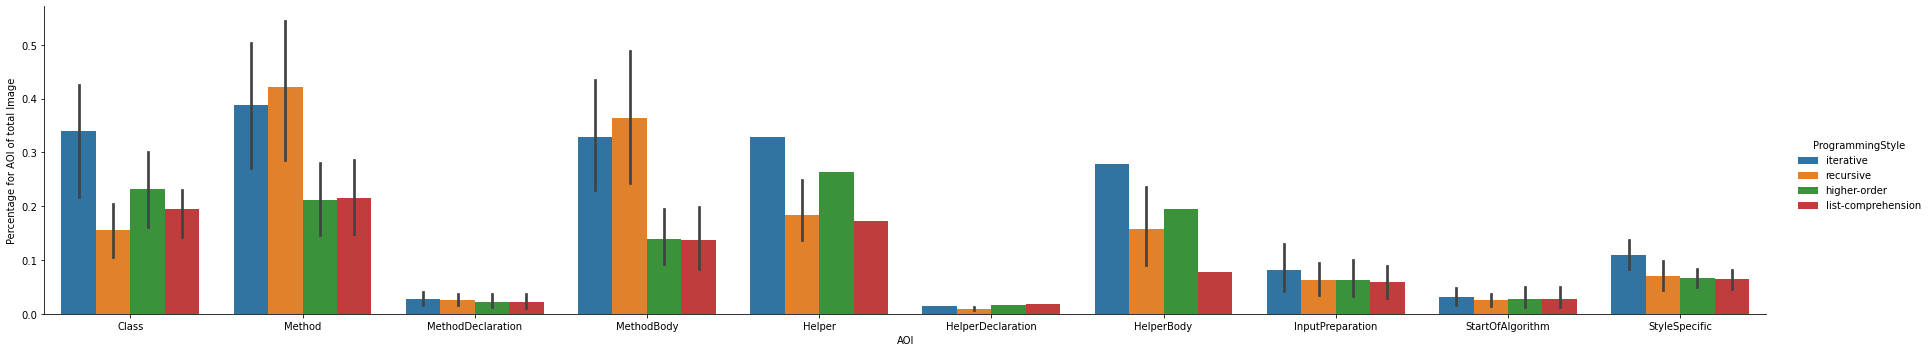

In [22]:

ax = sns.catplot(x="AOI", y="Percentage", hue="ProgrammingStyle", data=df_confounding_aoi, kind="bar", height=5,
                 aspect=5, hue_order=["iterative", "recursive", "higher-order", "list-comprehension"],
                 order=aoi_order)
ax.tight_layout()
ax.set(ylabel="Percentage for AOI of total Image")
plt.savefig("./results/ConfoundingFactors/figures/AOI_Size_in_Image.png")
plt.show()
plt.close('all')

In [24]:
df_tmp = df_confounding_aoi.groupby(["ProgrammingStyle", "AOI"])["Percentage"].describe()
df_tmp.to_excel("./results/ConfoundingFactors/data/AOI_Size_in_Image.xlsx")